# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

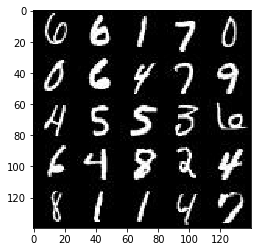

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

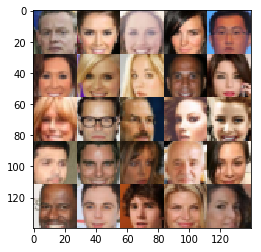

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    ip_real = tf.placeholder(tf.float32,shape=(None,image_width,image_height,image_channels))
    ip_z = tf.placeholder(tf.float32,shape=(None,z_dim))
    learning_rate = tf.placeholder(tf.float32)
    return ip_real,ip_z,learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [23]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.15
    with tf.variable_scope('discriminator',reuse=reuse):
        x1 = tf.layers.conv2d(images,64,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha*x1,x1)
        
        x2 = tf.layers.conv2d(x1,128,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.maximum(alpha*x2,x2)
        x2 = tf.layers.batch_normalization(x2,training=True)
        x2 = tf.layers.dropout(x2, rate =0.2)
        
        x3 = tf.layers.conv2d(x2,256,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.maximum(alpha*x3,x3)
        x3 = tf.layers.batch_normalization(x3,training=True)
        x3 = tf.layers.dropout(x3, rate =0.2)
        
        x4 = tf.layers.conv2d(x3,512,5,strides=1,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.maximum(alpha*x4,x4)
        x4 = tf.layers.batch_normalization(x4,training=True)
        x4 = tf.layers.dropout(x4, rate =0.2)
        
        x5 = tf.layers.conv2d(x4,1024,5,strides=1,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x5 = tf.maximum(alpha*x5,x5)
        x5 = tf.layers.batch_normalization(x5,training=True)
        x5 = tf.layers.dropout(x5, rate =0.2)
        
        flatten = tf.reshape(x5,shape=(-1,4*4*1024))
        logits = tf.layers.dense(flatten,1,activation=None,kernel_initializer=tf.contrib.layers.xavier_initializer())
        output = tf.sigmoid(logits)
    return output,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.15
    with tf.variable_scope('generator',reuse=not is_train):
        x1 = tf.layers.dense(z,4*4*1024,kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.reshape(x1,shape=(-1,4,4,1024))
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = tf.maximum(x1*alpha,x1)

        x2 = tf.layers.conv2d_transpose(x1,512,4,strides=1,padding='valid',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        x2 = tf.maximum(x2*alpha,x2)
        x2 = tf.layers.dropout(x2, rate =0.2)

        x3 = tf.layers.conv2d_transpose(x2,256,5,strides=1,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3,training=is_train)
        x3 = tf.maximum(x3*alpha,x3)
        x3 = tf.layers.dropout(x3, rate =0.2)
        
        x4 = tf.layers.conv2d_transpose(x3,128,5,strides=2,padding='same',kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        x4 = tf.layers.batch_normalization(x4,training=is_train)
        x4 = tf.maximum(x4*alpha,x4)
        x4 = tf.layers.dropout(x4, rate =0.2)
        
        x5 = tf.layers.conv2d_transpose(x4,64,5,strides=1,padding='same',kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        x5 = tf.layers.batch_normalization(x5,training=is_train)
        x5 = tf.maximum(x5*alpha,x5)
        x5 = tf.layers.dropout(x5, rate =0.2)

        logits = tf.layers.conv2d_transpose(x5,out_channel_dim,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        output = tf.tanh(logits)
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.2
    g_model = generator(input_z,out_channel_dim)
    d_model_real,d_logits_real = discriminator(input_real,reuse=False)
    d_model_fake,d_logits_fake = discriminator(g_model,reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_model_real)* (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real+d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_model_fake)))
    return d_loss,g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    trainables = tf.trainable_variables()
    d_trainables = [var for var in trainables if var.name.startswith('discriminator')]
    g_trainables = [var for var in trainables if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(d_loss,var_list=d_trainables)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss,var_list=g_trainables)
    return d_train_opt,g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
%matplotlib inline
from matplotlib import pyplot as plt
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print("data shape {}, z_dim {}, image mode {}".format(data_shape,z_dim, data_image_mode))
    #saver = tf.train.Saver()
    #sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    samples, losses = [], []
    steps = 0
    channels = 1 if data_image_mode == "L" else 3
    ip_real_ph,ip_z_ph,learning_rate_ph = model_inputs(data_shape[1],data_shape[2],data_shape[3], z_dim)
    d_loss,g_loss = model_loss(ip_real_ph, ip_z_ph, channels)
    d_train_opt,g_train_opt = model_opt(d_loss, g_loss, learning_rate_ph, beta1)
    d_loss_vec=[]
    g_loss_vec=[]
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_opt,feed_dict={ip_real_ph:batch_images, ip_z_ph:batch_z,learning_rate_ph:learning_rate})
                _ = sess.run(g_train_opt,feed_dict={ip_real_ph:batch_images, ip_z_ph:batch_z,learning_rate_ph:learning_rate})
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({ip_real_ph:batch_images, ip_z_ph:batch_z,learning_rate_ph:learning_rate})
                    train_loss_g = g_loss.eval({ip_z_ph:batch_z,learning_rate_ph:learning_rate})
                    d_loss_vec.append(train_loss_d)
                    g_loss_vec.append(train_loss_g)
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                if steps % 200 == 0:
                    show_generator_output(sess, 64, ip_z_ph, channels, data_image_mode)
                    #saver.save(sess, './checkpoints/generator.ckpt')
        show_generator_output(sess, 64, ip_z_ph, channels, data_image_mode)
    Discriminator_loss, = plt.plot(d_loss_vec, color='b', label='Discriminator loss')
    Genereator_loss, = plt.plot(g_loss_vec, color='r', label='Generator loss')
    plt.legend(handles=[ Discriminator_loss, Genereator_loss])
    return
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

data shape (60000, 28, 28, 1), z_dim 100, image mode L
Epoch 1/2... Discriminator Loss: 15.4119... Generator Loss: 0.0000
Epoch 1/2... Discriminator Loss: 1.5329... Generator Loss: 7.5140
Epoch 1/2... Discriminator Loss: 1.3054... Generator Loss: 1.1771
Epoch 1/2... Discriminator Loss: 0.7295... Generator Loss: 3.8798
Epoch 1/2... Discriminator Loss: 2.2009... Generator Loss: 10.2200
Epoch 1/2... Discriminator Loss: 3.9571... Generator Loss: 0.0506
Epoch 1/2... Discriminator Loss: 2.1400... Generator Loss: 6.2145
Epoch 1/2... Discriminator Loss: 1.6873... Generator Loss: 5.9241
Epoch 1/2... Discriminator Loss: 3.5268... Generator Loss: 0.3086
Epoch 1/2... Discriminator Loss: 1.3452... Generator Loss: 0.8689
Epoch 1/2... Discriminator Loss: 1.3868... Generator Loss: 0.7604
Epoch 1/2... Discriminator Loss: 1.0188... Generator Loss: 2.4871
Epoch 1/2... Discriminator Loss: 1.0906... Generator Loss: 1.0137
Epoch 1/2... Discriminator Loss: 1.4208... Generator Loss: 0.9550
Epoch 1/2... Discri

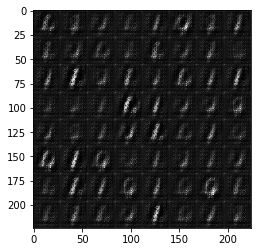

Epoch 1/2... Discriminator Loss: 1.7066... Generator Loss: 4.1207
Epoch 1/2... Discriminator Loss: 1.1355... Generator Loss: 2.4570
Epoch 1/2... Discriminator Loss: 2.4145... Generator Loss: 5.4859
Epoch 1/2... Discriminator Loss: 1.1840... Generator Loss: 2.6781
Epoch 1/2... Discriminator Loss: 1.4714... Generator Loss: 0.6846
Epoch 1/2... Discriminator Loss: 1.0442... Generator Loss: 1.1418
Epoch 1/2... Discriminator Loss: 3.2045... Generator Loss: 4.5334
Epoch 1/2... Discriminator Loss: 1.3599... Generator Loss: 0.8932
Epoch 1/2... Discriminator Loss: 1.9789... Generator Loss: 3.0336
Epoch 1/2... Discriminator Loss: 1.4217... Generator Loss: 1.9416
Epoch 1/2... Discriminator Loss: 1.5870... Generator Loss: 2.1891
Epoch 1/2... Discriminator Loss: 1.1966... Generator Loss: 1.6426
Epoch 1/2... Discriminator Loss: 1.7122... Generator Loss: 2.3006
Epoch 1/2... Discriminator Loss: 1.5057... Generator Loss: 1.8451
Epoch 1/2... Discriminator Loss: 1.3992... Generator Loss: 1.8126
Epoch 1/2.

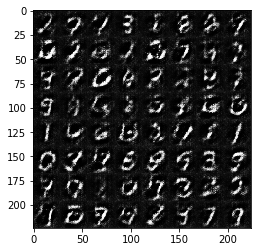

Epoch 1/2... Discriminator Loss: 1.1838... Generator Loss: 1.4912
Epoch 1/2... Discriminator Loss: 1.2944... Generator Loss: 0.7213
Epoch 1/2... Discriminator Loss: 1.7739... Generator Loss: 0.4137
Epoch 1/2... Discriminator Loss: 1.2506... Generator Loss: 0.8821
Epoch 1/2... Discriminator Loss: 1.2203... Generator Loss: 1.0863
Epoch 1/2... Discriminator Loss: 1.8450... Generator Loss: 3.0116
Epoch 1/2... Discriminator Loss: 2.5683... Generator Loss: 2.5128
Epoch 1/2... Discriminator Loss: 1.3153... Generator Loss: 1.1225
Epoch 1/2... Discriminator Loss: 1.4591... Generator Loss: 1.7405
Epoch 1/2... Discriminator Loss: 1.4213... Generator Loss: 2.0919
Epoch 1/2... Discriminator Loss: 1.5939... Generator Loss: 2.6053
Epoch 1/2... Discriminator Loss: 1.5539... Generator Loss: 2.5653
Epoch 1/2... Discriminator Loss: 1.4506... Generator Loss: 0.6806
Epoch 1/2... Discriminator Loss: 1.3787... Generator Loss: 2.0879
Epoch 1/2... Discriminator Loss: 1.1187... Generator Loss: 1.3184
Epoch 1/2.

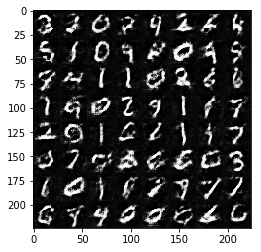

Epoch 1/2... Discriminator Loss: 1.3556... Generator Loss: 1.3872
Epoch 1/2... Discriminator Loss: 1.1586... Generator Loss: 0.8790
Epoch 1/2... Discriminator Loss: 1.6903... Generator Loss: 0.4703
Epoch 1/2... Discriminator Loss: 1.2418... Generator Loss: 0.9807
Epoch 1/2... Discriminator Loss: 1.1852... Generator Loss: 0.9608
Epoch 1/2... Discriminator Loss: 1.2622... Generator Loss: 1.1183
Epoch 1/2... Discriminator Loss: 1.4589... Generator Loss: 1.2995
Epoch 1/2... Discriminator Loss: 1.3312... Generator Loss: 0.8475
Epoch 1/2... Discriminator Loss: 1.6749... Generator Loss: 1.9007
Epoch 1/2... Discriminator Loss: 1.2605... Generator Loss: 1.6457
Epoch 1/2... Discriminator Loss: 1.2074... Generator Loss: 1.8854
Epoch 1/2... Discriminator Loss: 1.4368... Generator Loss: 0.6116
Epoch 1/2... Discriminator Loss: 1.6781... Generator Loss: 2.4193
Epoch 1/2... Discriminator Loss: 1.3407... Generator Loss: 1.4620
Epoch 1/2... Discriminator Loss: 1.2578... Generator Loss: 0.8025
Epoch 1/2.

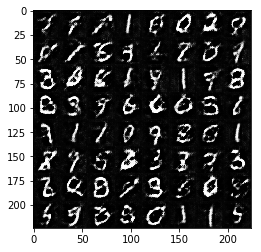

Epoch 1/2... Discriminator Loss: 1.4441... Generator Loss: 0.6148
Epoch 1/2... Discriminator Loss: 0.9601... Generator Loss: 1.7215
Epoch 1/2... Discriminator Loss: 1.2183... Generator Loss: 1.3886
Epoch 1/2... Discriminator Loss: 1.5115... Generator Loss: 1.0643
Epoch 1/2... Discriminator Loss: 1.2545... Generator Loss: 2.8223
Epoch 1/2... Discriminator Loss: 1.7900... Generator Loss: 0.6245
Epoch 1/2... Discriminator Loss: 1.6731... Generator Loss: 2.3307
Epoch 1/2... Discriminator Loss: 1.2792... Generator Loss: 1.2588
Epoch 1/2... Discriminator Loss: 1.0061... Generator Loss: 1.2838
Epoch 1/2... Discriminator Loss: 1.0111... Generator Loss: 1.1152
Epoch 1/2... Discriminator Loss: 0.9888... Generator Loss: 1.7634
Epoch 1/2... Discriminator Loss: 1.1704... Generator Loss: 1.3670
Epoch 1/2... Discriminator Loss: 1.5717... Generator Loss: 0.5202
Epoch 2/2... Discriminator Loss: 1.3981... Generator Loss: 1.6084
Epoch 2/2... Discriminator Loss: 1.1264... Generator Loss: 1.2822
Epoch 2/2.

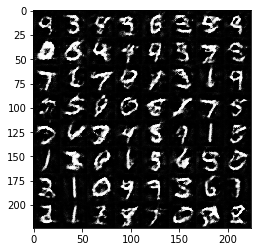

Epoch 2/2... Discriminator Loss: 1.1992... Generator Loss: 1.3099
Epoch 2/2... Discriminator Loss: 1.4312... Generator Loss: 1.4058
Epoch 2/2... Discriminator Loss: 1.1434... Generator Loss: 1.4894
Epoch 2/2... Discriminator Loss: 1.3942... Generator Loss: 2.7253
Epoch 2/2... Discriminator Loss: 1.1300... Generator Loss: 1.4805
Epoch 2/2... Discriminator Loss: 0.9872... Generator Loss: 1.2553
Epoch 2/2... Discriminator Loss: 1.3011... Generator Loss: 1.9672
Epoch 2/2... Discriminator Loss: 1.4118... Generator Loss: 1.1829
Epoch 2/2... Discriminator Loss: 1.5891... Generator Loss: 1.8468
Epoch 2/2... Discriminator Loss: 1.5900... Generator Loss: 0.6971
Epoch 2/2... Discriminator Loss: 1.5570... Generator Loss: 0.6201
Epoch 2/2... Discriminator Loss: 1.3921... Generator Loss: 1.1045
Epoch 2/2... Discriminator Loss: 1.2426... Generator Loss: 1.3676
Epoch 2/2... Discriminator Loss: 1.3970... Generator Loss: 1.0569
Epoch 2/2... Discriminator Loss: 1.2286... Generator Loss: 1.3151
Epoch 2/2.

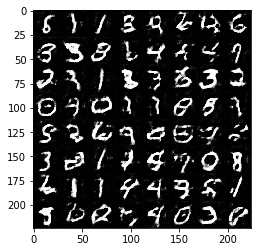

Epoch 2/2... Discriminator Loss: 1.4917... Generator Loss: 0.6093
Epoch 2/2... Discriminator Loss: 1.3034... Generator Loss: 1.7773
Epoch 2/2... Discriminator Loss: 1.6317... Generator Loss: 0.5171
Epoch 2/2... Discriminator Loss: 0.8863... Generator Loss: 1.3331
Epoch 2/2... Discriminator Loss: 1.4231... Generator Loss: 0.6142
Epoch 2/2... Discriminator Loss: 1.0802... Generator Loss: 1.5228
Epoch 2/2... Discriminator Loss: 3.5375... Generator Loss: 3.0564
Epoch 2/2... Discriminator Loss: 1.7100... Generator Loss: 0.6342
Epoch 2/2... Discriminator Loss: 1.3936... Generator Loss: 1.5071
Epoch 2/2... Discriminator Loss: 1.5595... Generator Loss: 0.5371
Epoch 2/2... Discriminator Loss: 1.5044... Generator Loss: 0.6489
Epoch 2/2... Discriminator Loss: 1.1835... Generator Loss: 1.1267
Epoch 2/2... Discriminator Loss: 1.1779... Generator Loss: 1.2650
Epoch 2/2... Discriminator Loss: 1.7647... Generator Loss: 0.4616
Epoch 2/2... Discriminator Loss: 3.9296... Generator Loss: 3.9554
Epoch 2/2.

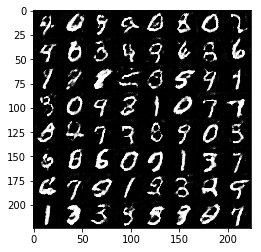

Epoch 2/2... Discriminator Loss: 1.1471... Generator Loss: 2.0876
Epoch 2/2... Discriminator Loss: 1.0686... Generator Loss: 1.1513
Epoch 2/2... Discriminator Loss: 0.9463... Generator Loss: 1.9053
Epoch 2/2... Discriminator Loss: 1.3382... Generator Loss: 0.7254
Epoch 2/2... Discriminator Loss: 1.3695... Generator Loss: 0.6425
Epoch 2/2... Discriminator Loss: 0.9981... Generator Loss: 2.1892
Epoch 2/2... Discriminator Loss: 1.1007... Generator Loss: 1.5149
Epoch 2/2... Discriminator Loss: 1.9880... Generator Loss: 0.3687
Epoch 2/2... Discriminator Loss: 1.2742... Generator Loss: 2.3477
Epoch 2/2... Discriminator Loss: 2.1965... Generator Loss: 0.3100
Epoch 2/2... Discriminator Loss: 1.1289... Generator Loss: 0.8850
Epoch 2/2... Discriminator Loss: 1.3272... Generator Loss: 3.0119
Epoch 2/2... Discriminator Loss: 1.9586... Generator Loss: 3.1724
Epoch 2/2... Discriminator Loss: 1.6255... Generator Loss: 0.5674
Epoch 2/2... Discriminator Loss: 1.8706... Generator Loss: 0.4309
Epoch 2/2.

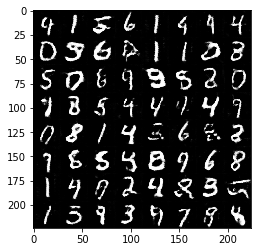

Epoch 2/2... Discriminator Loss: 1.3685... Generator Loss: 0.7002
Epoch 2/2... Discriminator Loss: 1.4351... Generator Loss: 0.6735
Epoch 2/2... Discriminator Loss: 1.2311... Generator Loss: 1.0600
Epoch 2/2... Discriminator Loss: 1.2274... Generator Loss: 0.8433
Epoch 2/2... Discriminator Loss: 1.0319... Generator Loss: 1.0593
Epoch 2/2... Discriminator Loss: 2.1293... Generator Loss: 4.5693
Epoch 2/2... Discriminator Loss: 0.9455... Generator Loss: 1.5129
Epoch 2/2... Discriminator Loss: 1.1602... Generator Loss: 2.2109
Epoch 2/2... Discriminator Loss: 1.4265... Generator Loss: 0.6035
Epoch 2/2... Discriminator Loss: 0.9969... Generator Loss: 1.5577
Epoch 2/2... Discriminator Loss: 0.9672... Generator Loss: 1.4007
Epoch 2/2... Discriminator Loss: 3.1207... Generator Loss: 5.6290
Epoch 2/2... Discriminator Loss: 1.1628... Generator Loss: 0.9013
Epoch 2/2... Discriminator Loss: 1.3884... Generator Loss: 1.8776
Epoch 2/2... Discriminator Loss: 1.0378... Generator Loss: 1.4693
Epoch 2/2.

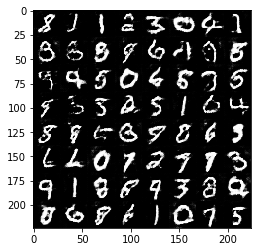

Epoch 2/2... Discriminator Loss: 2.4013... Generator Loss: 0.4274
Epoch 2/2... Discriminator Loss: 1.5971... Generator Loss: 0.8172
Epoch 2/2... Discriminator Loss: 1.0003... Generator Loss: 1.1966
Epoch 2/2... Discriminator Loss: 1.0776... Generator Loss: 1.9214
Epoch 2/2... Discriminator Loss: 0.7728... Generator Loss: 1.5754
Epoch 2/2... Discriminator Loss: 0.9435... Generator Loss: 1.2065
Epoch 2/2... Discriminator Loss: 1.8176... Generator Loss: 1.6235


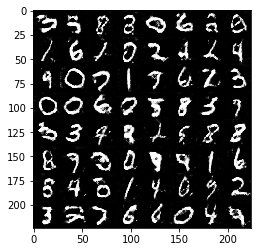

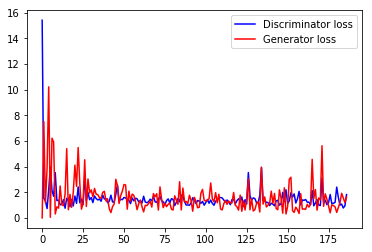

In [24]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

data shape (202599, 28, 28, 3), z_dim 128, image mode RGB
Epoch 1/1... Discriminator Loss: 8.2337... Generator Loss: 77.1032
Epoch 1/1... Discriminator Loss: 2.4856... Generator Loss: 21.0115
Epoch 1/1... Discriminator Loss: 5.5281... Generator Loss: 51.9534
Epoch 1/1... Discriminator Loss: 5.4721... Generator Loss: 22.4002
Epoch 1/1... Discriminator Loss: 4.5121... Generator Loss: 15.1123
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 1.2108
Epoch 1/1... Discriminator Loss: 0.8856... Generator Loss: 5.4414
Epoch 1/1... Discriminator Loss: 0.7672... Generator Loss: 4.4229
Epoch 1/1... Discriminator Loss: 0.5793... Generator Loss: 3.7380
Epoch 1/1... Discriminator Loss: 0.6193... Generator Loss: 5.2919
Epoch 1/1... Discriminator Loss: 0.6097... Generator Loss: 3.6901
Epoch 1/1... Discriminator Loss: 2.1617... Generator Loss: 0.3607
Epoch 1/1... Discriminator Loss: 3.1030... Generator Loss: 6.1045
Epoch 1/1... Discriminator Loss: 3.0911... Generator Loss: 6.6858
Epoch 1/1... 

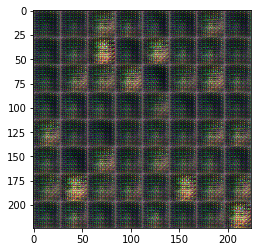

Epoch 1/1... Discriminator Loss: 2.9131... Generator Loss: 4.7414
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 2.2700
Epoch 1/1... Discriminator Loss: 2.0264... Generator Loss: 2.8797
Epoch 1/1... Discriminator Loss: 2.0841... Generator Loss: 0.3227
Epoch 1/1... Discriminator Loss: 2.9742... Generator Loss: 5.3516
Epoch 1/1... Discriminator Loss: 2.1386... Generator Loss: 2.8941
Epoch 1/1... Discriminator Loss: 1.7841... Generator Loss: 2.6609
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.9874
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.5570... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 1.5939... Generator Loss: 0.5548
Epoch 1/1... Discriminator Loss: 1.6473... Generator Loss: 0.5777
Epoch 1/1... Discriminator Loss: 1.5080... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.7819
Epoch 1/1.

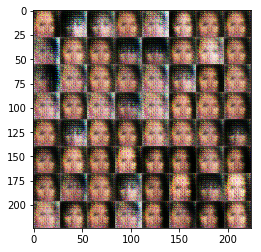

Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 1.3484
Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 1.0144
Epoch 1/1... Discriminator Loss: 1.9518... Generator Loss: 0.4157
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 2.6178
Epoch 1/1... Discriminator Loss: 1.5112... Generator Loss: 2.3346
Epoch 1/1... Discriminator Loss: 1.9301... Generator Loss: 2.4330
Epoch 1/1... Discriminator Loss: 1.6754... Generator Loss: 2.2501
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 1.5350
Epoch 1/1... Discriminator Loss: 1.9021... Generator Loss: 0.4700
Epoch 1/1... Discriminator Loss: 1.7184... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.6146... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.6591... Generator Loss: 0.5207
Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 0.6442
Epoch 1/1.

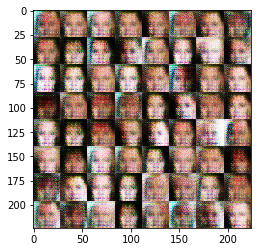

Epoch 1/1... Discriminator Loss: 1.1313... Generator Loss: 0.9746
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 2.1044
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 1.9273
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 2.1018
Epoch 1/1... Discriminator Loss: 1.5647... Generator Loss: 1.7563
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 1.5840
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 1.0470
Epoch 1/1... Discriminator Loss: 1.8230... Generator Loss: 0.4588
Epoch 1/1... Discriminator Loss: 1.6848... Generator Loss: 0.4935
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.8566... Generator Loss: 0.3607
Epoch 1/1... Discriminator Loss: 1.0217... Generator Loss: 1.0406
Epoch 1/1... Discriminator Loss: 1.1336... Generator Loss: 1.2767
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 2.3897
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.9073
Epoch 1/1.

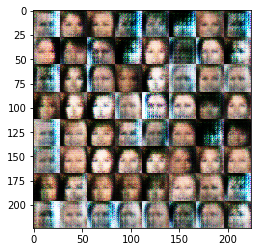

Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 1.5090
Epoch 1/1... Discriminator Loss: 1.5542... Generator Loss: 2.8346
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 1.3414
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 1.3379
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 1.1496
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 1.4409
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 1.5769
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 1.2772
Epoch 1/1... Discriminator Loss: 1.6380... Generator Loss: 1.5886
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.5346... Generator Loss: 0.5773
Epoch 1/1.

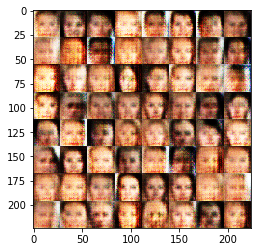

Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 0.9681
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 0.9078
Epoch 1/1... Discriminator Loss: 1.8743... Generator Loss: 0.4082
Epoch 1/1... Discriminator Loss: 1.5789... Generator Loss: 1.2286
Epoch 1/1... Discriminator Loss: 1.5292... Generator Loss: 1.8652
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 1.2391
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 1.6128
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 1.0916
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 1.4067
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 1.4413
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 1.5294
Epoch 1/1... Discriminator Loss: 0.9483... Generator Loss: 1.2025
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 1.7811
Epoch 1/1... Discriminator Loss: 0.8022... Generator Loss: 1.7161
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 1.5479
Epoch 1/1.

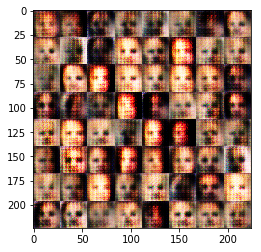

Epoch 1/1... Discriminator Loss: 1.1022... Generator Loss: 1.6546
Epoch 1/1... Discriminator Loss: 1.5782... Generator Loss: 0.5957
Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 0.9525
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 1.5406
Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 1.0806
Epoch 1/1... Discriminator Loss: 1.7361... Generator Loss: 3.3400
Epoch 1/1... Discriminator Loss: 1.6622... Generator Loss: 2.7813
Epoch 1/1... Discriminator Loss: 1.1520... Generator Loss: 1.8737
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 1.6956
Epoch 1/1... Discriminator Loss: 1.0896... Generator Loss: 1.1106
Epoch 1/1... Discriminator Loss: 1.5185... Generator Loss: 1.4476
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 0.9788
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 2.3691
Epoch 1/1... Discriminator Loss: 1.6331... Generator Loss: 1.8951
Epoch 1/1... Discriminator Loss: 1.1420... Generator Loss: 3.7054
Epoch 1/1.

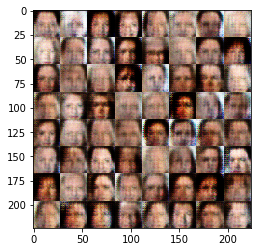

Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.5450
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 1.3409
Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 1.4108
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 2.0227
Epoch 1/1... Discriminator Loss: 1.0482... Generator Loss: 2.0275
Epoch 1/1... Discriminator Loss: 0.6898... Generator Loss: 2.5645
Epoch 1/1... Discriminator Loss: 0.8566... Generator Loss: 3.4243
Epoch 1/1... Discriminator Loss: 0.9732... Generator Loss: 3.3792
Epoch 1/1... Discriminator Loss: 0.8459... Generator Loss: 1.9970
Epoch 1/1... Discriminator Loss: 0.8145... Generator Loss: 1.7834
Epoch 1/1... Discriminator Loss: 1.9549... Generator Loss: 0.3647
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 2.6047
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.6689... Generator Loss: 2.1159
Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 1.5350
Epoch 1/1.

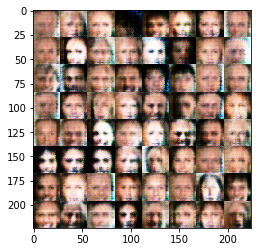

Epoch 1/1... Discriminator Loss: 1.0265... Generator Loss: 1.3936
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 0.9822
Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 0.8987
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.9751
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 2.1108
Epoch 1/1... Discriminator Loss: 1.2287... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 1.3561
Epoch 1/1... Discriminator Loss: 0.6907... Generator Loss: 2.1824
Epoch 1/1... Discriminator Loss: 0.6524... Generator Loss: 2.1591
Epoch 1/1... Discriminator Loss: 0.9529... Generator Loss: 1.4250
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 1.0483
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.8331... Generator Loss: 0.4920
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 1.3080
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 1.1150
Epoch 1/1.

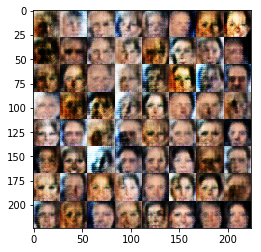

Epoch 1/1... Discriminator Loss: 1.1813... Generator Loss: 1.5338
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 1.0609
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 1.9179
Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 1.5150
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.5805
Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 0.9713
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 1.4887
Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 1.1526
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 1.7261
Epoch 1/1... Discriminator Loss: 1.0469... Generator Loss: 1.0819
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 2.0095
Epoch 1/1.

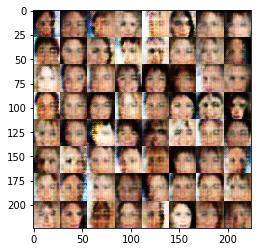

Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.9680
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 2.4169
Epoch 1/1... Discriminator Loss: 1.5109... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.8039... Generator Loss: 3.1303
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.6010... Generator Loss: 0.5229
Epoch 1/1... Discriminator Loss: 1.1359... Generator Loss: 0.9702
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.5338... Generator Loss: 1.9714
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 0.9113
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 1.7103
Epoch 1/1... Discriminator Loss: 2.1431... Generator Loss: 0.2789
Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 1.0171
Epoch 1/1... Discriminator Loss: 1.5345... Generator Loss: 0.5112
Epoch 1/1.

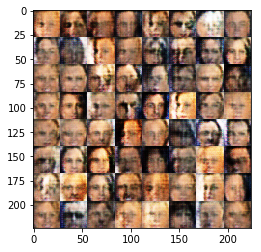

Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.0904... Generator Loss: 1.4980
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 2.1932
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 1.0694
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.0289... Generator Loss: 1.0826
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 1.2324
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 1.7256
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 1.2238
Epoch 1/1... Discriminator Loss: 1.4958... Generator Loss: 0.4985
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 1.5997
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.5468... Generator Loss: 1.2226
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 0.7851
Epoch 1/1.

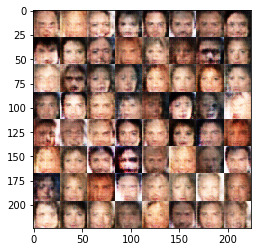

Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.1405... Generator Loss: 1.0650
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 1.6988
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 1.1118
Epoch 1/1... Discriminator Loss: 1.2445... Generator Loss: 0.9833
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 1.6293
Epoch 1/1... Discriminator Loss: 1.8634... Generator Loss: 2.5876
Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 1.6285
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 1.0073
Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 1.1486
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 2.3290
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.5413
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 2.2762
Epoch 1/1.

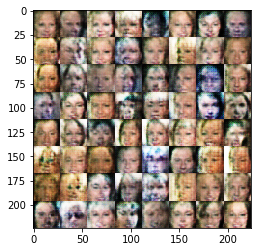

Epoch 1/1... Discriminator Loss: 1.5423... Generator Loss: 1.3160
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 0.9463
Epoch 1/1... Discriminator Loss: 0.8220... Generator Loss: 2.0780
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 1.1106
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 1.1882
Epoch 1/1... Discriminator Loss: 1.6972... Generator Loss: 2.1761
Epoch 1/1... Discriminator Loss: 1.5446... Generator Loss: 0.4866
Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 1.1253
Epoch 1/1... Discriminator Loss: 1.9105... Generator Loss: 1.7151
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 1.6461
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 1.5636
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 1.2489
Epoch 1/1.

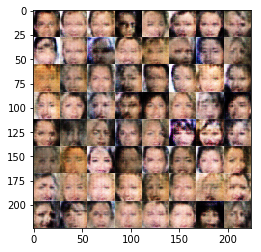

Epoch 1/1... Discriminator Loss: 1.8675... Generator Loss: 0.4650
Epoch 1/1... Discriminator Loss: 1.6896... Generator Loss: 0.4075
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.8727
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.6132
Epoch 1/1... Discriminator Loss: 1.5177... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 2.3690... Generator Loss: 2.4458
Epoch 1/1... Discriminator Loss: 1.6819... Generator Loss: 1.6655
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 1.3660
Epoch 1/1... Discriminator Loss: 1.6155... Generator Loss: 1.7506
Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 1.9652... Generator Loss: 1.8230
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 1.3093
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.9969
Epoch 1/1.

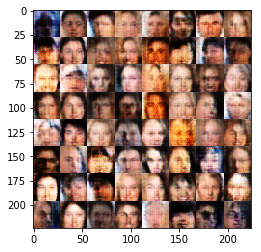

Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.9612
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 1.0695
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 1.3447
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.9930
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 1.0272
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 1.1425
Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 1.3255
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 1.1227
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 1.9297
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 1.2469
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 1.1969
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 1.0772
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 1.3610
Epoch 1/1.

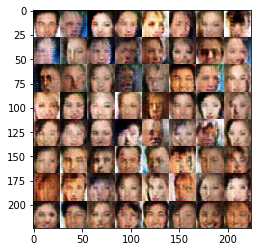

Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 1.1221
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 1.0612
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.9214
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 1.2809
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.8787
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 1.2869
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 0.9282
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.5543
Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 1.1193
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 0.5122
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 0.8942
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.6678
Epoch 1/1.

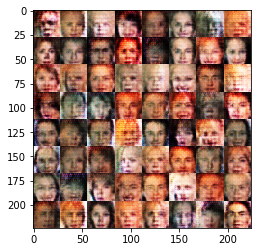

Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 1.9746
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 1.7688
Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 0.9177
Epoch 1/1... Discriminator Loss: 1.0655... Generator Loss: 1.2820
Epoch 1/1... Discriminator Loss: 1.0620... Generator Loss: 1.0859
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 1.5919
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 0.9226
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 1.3208
Epoch 1/1... Discriminator Loss: 1.5148... Generator Loss: 1.2806
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 1.4465


In [ ]:
batch_size = 32
z_dim = 128
learning_rate = 0.0003
beta1 = 0.25


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.